In [1]:
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
from datetime import timezone, timedelta
from scipy.signal import argrelextrema
import pandas as pd

In [2]:
log_fname = "/home/sparrow/soft/transloc/log.tsv"

In [4]:
log = pd.read_csv(log_fname,sep="\t",names=["sid","vid","timestamp","dist"])
print(len(log))
log.head()

108068


,sid,vid,timestamp,dist
0,4177254,4019357,1668193070000,2661.114780
1,4265754,4019357,1668193070000,1969.361439
2,4177254,4019321,1668193143000,4284.777911
3,4265754,4019321,1668193143000,12.981737
4,4177254,4019327,1668193159000,15.220122


(4177254, 4019313)


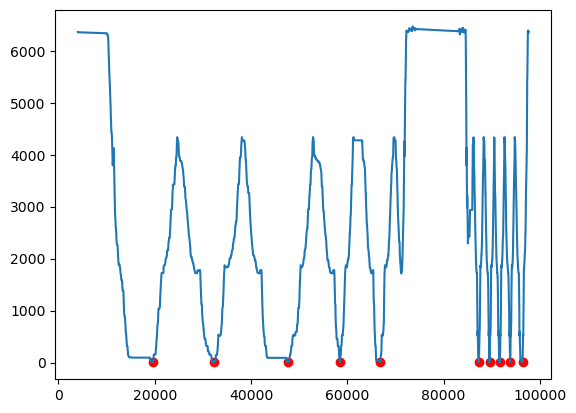

(4177254, 4019315)


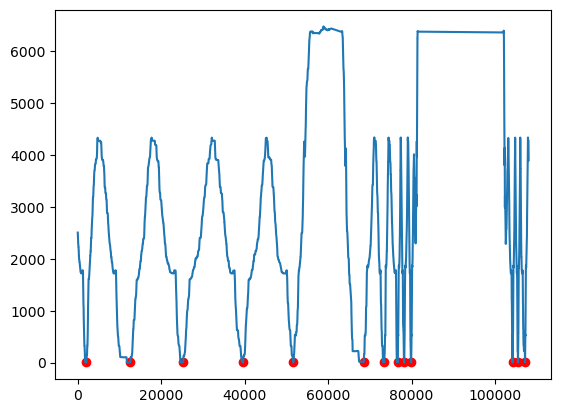

(4177254, 4019321)


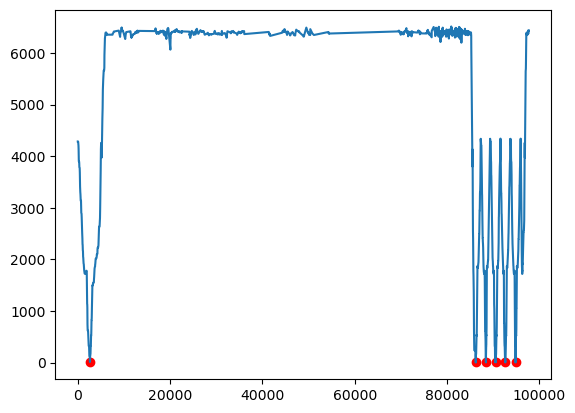

(4177254, 4019323)


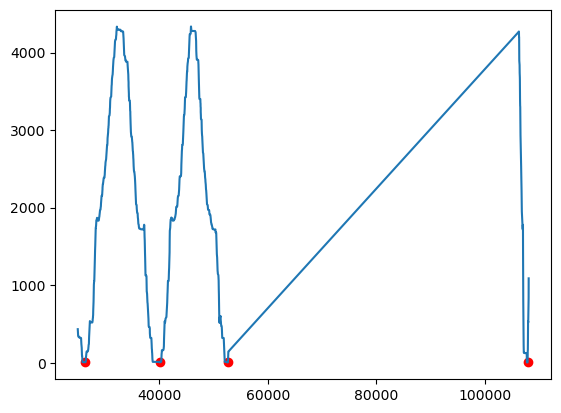

(4177254, 4019327)


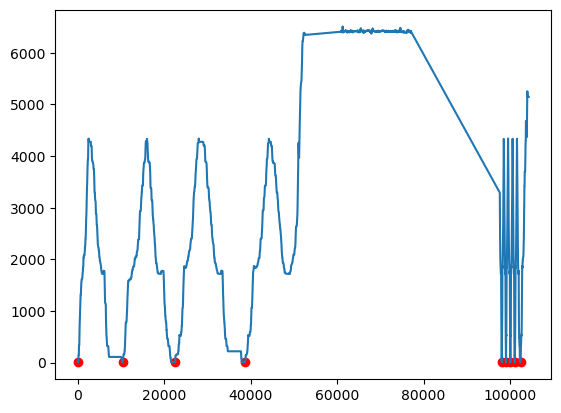

(4177254, 4019347)


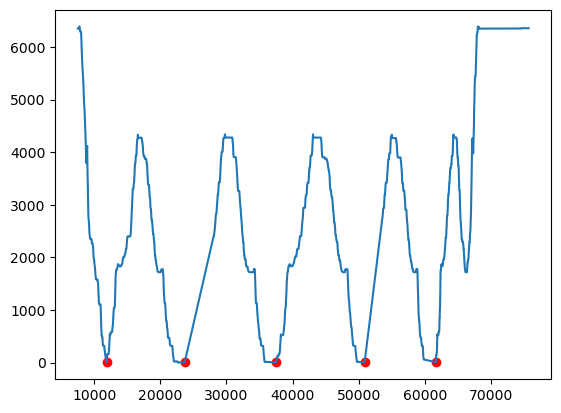

(4177254, 4019351)


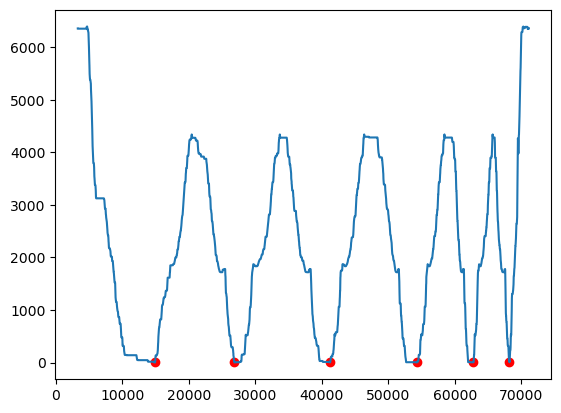

(4177254, 4019357)


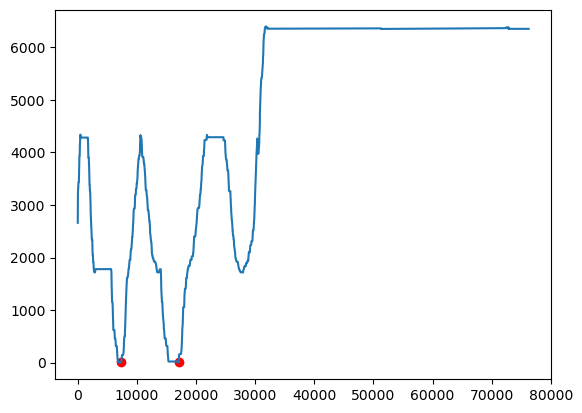

(4177254, 4019375)


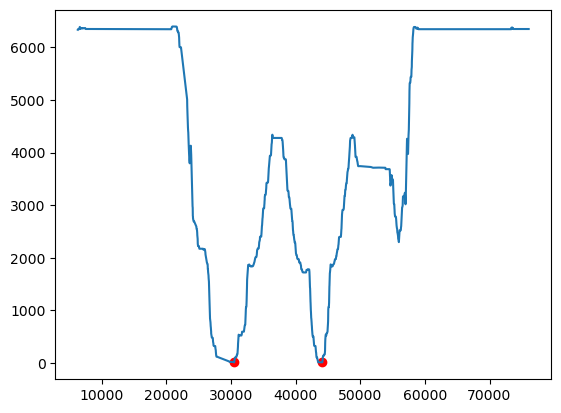

(4177254, 4019377)


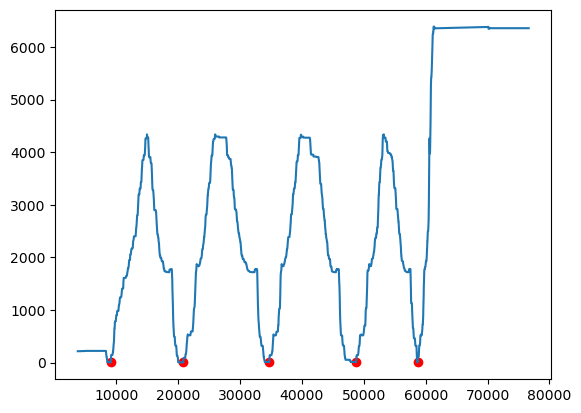

(4265754, 4019313)


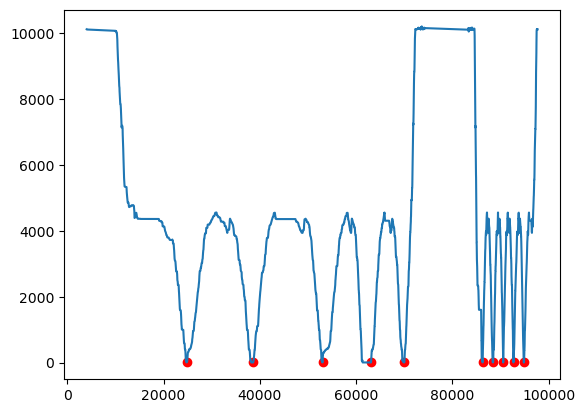

(4265754, 4019315)


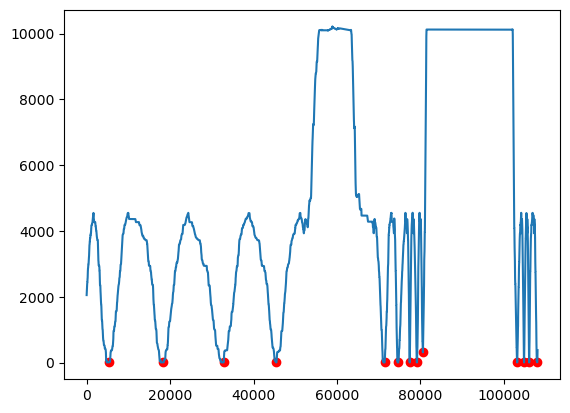

(4265754, 4019321)


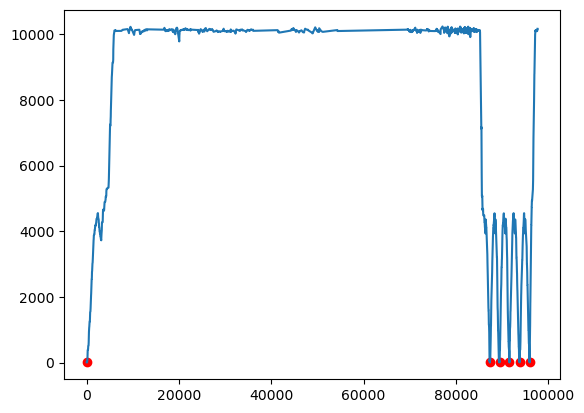

(4265754, 4019323)


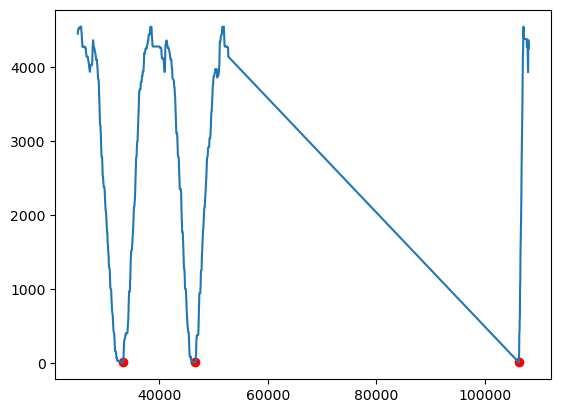

(4265754, 4019327)


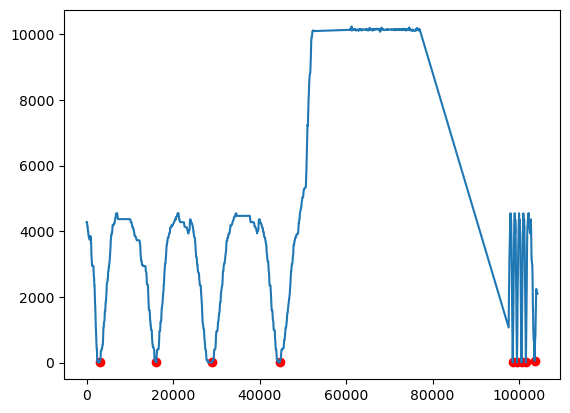

(4265754, 4019347)


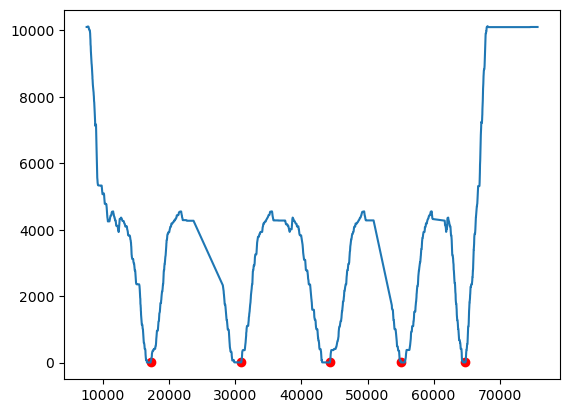

(4265754, 4019351)


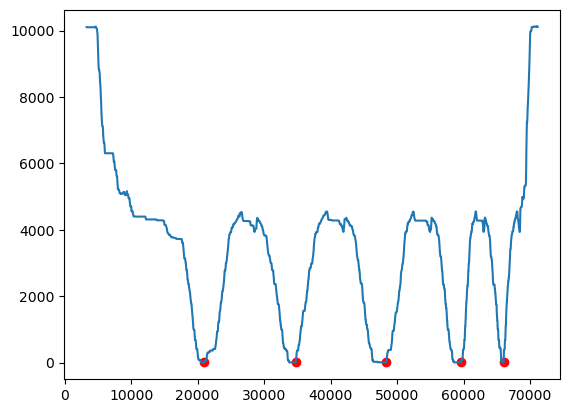

(4265754, 4019357)


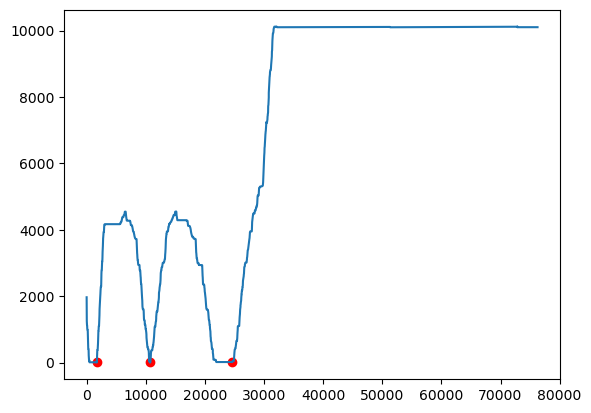

(4265754, 4019375)


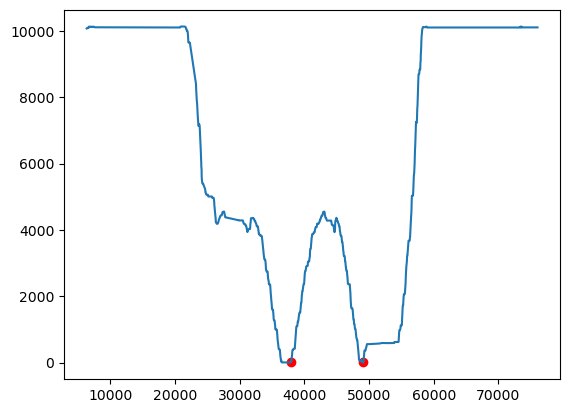

(4265754, 4019377)


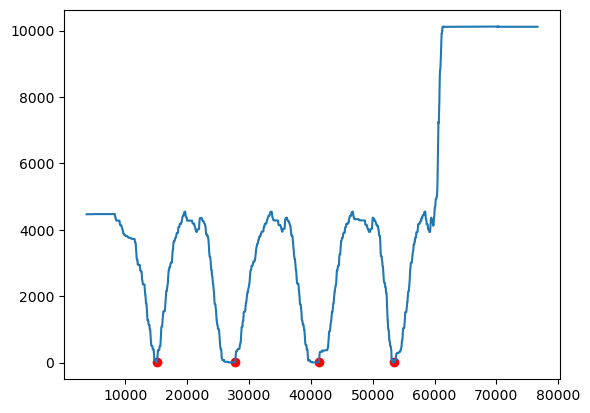

In [5]:
n=100
max_time_diff = 1200000 # 20 minutes in unix time
min_distance = 3500 # distance between the two stops

times = []

glog = log.groupby(by=["sid","vid"])
grp = ""
for name,grp in glog:
    print(name)
    # Find local peaks
#     grp['min'] = grp.dist[(grp.dist.shift(1) > grp.dist) & (grp.dist.shift(-1) > grp.dist) & (grp.dist<=100)]
    
    grp['min'] = grp.iloc[argrelextrema(grp.dist.values, np.less_equal,
                    order=n)[0]]['dist']
    grp["min"] = grp[~(grp["min"].isna())&(grp["min"]<500)]["min"]
    
    
    # remove duplicates close in time
    sub = grp[~(grp["min"].isna())].reset_index(drop=True)

    sub["group_diff"] = sub.sort_values("timestamp")["timestamp"]\
                         .diff()\
                         .gt(max_time_diff)\
                         .cumsum()

    sub_grp_diff = pd.DataFrame(sub.groupby(by="group_diff").max()).reset_index()
    grp["min"] = grp[~(grp["min"].isna())&(grp["timestamp"].isin(sub_grp_diff["timestamp"]))]["min"]
    
    
    # we probably should also make sure that the bus actually went somewhere meaningful 
    # and not just circled around without passengers
    
    # can be done as:
    # compute distance between the two endpoints
    # get maximum distance between two inferred stops
    # if not within n% of the total route distance
    
    idxs = list(grp[~(grp["min"].isna())].index)
    
    good_idxs = []
    
    if len(idxs)>=1:
        good_idxs.append(idxs[0])

    if len(idxs)>1:
        for i in idxs[1:]:
            max_dist_between = grp.loc[good_idxs[-1]:i]["dist"].max()
            if max_dist_between<=min_distance:
                good_idxs[-1] = i
            else:
                good_idxs.append(i)
                
    grp["min"] = grp[~(grp["min"].isna())&(grp.index.isin(good_idxs))]["min"]
    grp["time"] = pd.to_datetime(grp[~(grp["min"].isna())]["timestamp"],unit='ms',utc=True).dt.tz_convert("US/Central").dt.time
    
#     if name==(4265754, 4019327):
#         print(len(sub_grp_diff))
#         plt.scatter(grp.index, grp['min'], c='r')
#         grp.dist.plot()
#         plt.show()
        
#         break
        
    plt.scatter(grp.index, grp['min'], c='r')
    grp.dist.plot()
    plt.show()
    
    # add times
    for t in list(grp[~(grp["min"].isna())]["time"]):
        times.append(t)

In [6]:
format = '%I:%M%p'

broadway_times_weekday = ["6:00am","12:00pm","5:18pm","6:15am","12:15pm","5:24pm","6:30am","12:30pm","5:30pm","6:45am","12:45pm","5:36pm","7:00am","1:00pm","5:42pm","7:15am","1:15pm","5:48pm","7:30am","1:30pm","5:54pm","7:36am","1:45pm","6:00pm","7:42am","2:00pm","6:10pm","7:48am","2:15pm","6:20pm","7:54am","2:30pm","6:30pm","8:00am","2:45pm","6:45pm","8:06am","3:00pm","7:00pm","8:12am","3:06pm","7:15pm","8:18am","3:12pm","7:30pm","8:24am","3:18pm","7:45pm","8:30am","3:24pm","8:00pm","8:36am","3:30pm","8:15pm","8:42am","3:36pm","8:30pm","8:48am","3:42pm","9:00pm","8:54am","3:48pm","9:30pm","9:00am","3:54pm","10:00pm","9:10am","4:00pm","10:30pm","9:20am","4:06pm","11:00pm","9:30am","4:12pm","11:30pm","9:40am","4:18pm","9:50am","4:24pm","10:00am","4:30pm","12:00am","10:15am","4:36pm","12:30am","10:30am","4:42pm","10:45am","4:48pm","11:00am","4:54pm","11:15am","5:00pm","11:30am","5:06pm","11:45am","5:12pm"]
broadway_times_weekday = [[datetime.time(datetime.strptime(x,format)),0] for x in broadway_times_weekday]

interfaith_times_weekday = ["6:00am","12:00pm","5:54pm","6:15am","12:15pm","6:00pm","6:30am","12:30pm","6:10pm","6:45am","12:45pm","6:20pm","7:00am","1:00pm","6:30pm","7:15am","1:15pm","6:40pm","7:30am","1:30pm","6:50pm","7:36am","1:45pm","7:00pm","7:42am","2:00pm","7:15pm","7:48am","2:15pm","7:30pm","7:54am","2:30pm","7:45pm","8:00am","2:45pm","8:00pm","8:06am","3:00pm","8:15pm","8:12am","3:15pm","8:30pm","8:18am","3:30pm","8:45pm","8:24am","3:36pm","9:00pm","8:30am","3:42pm","9:30pm","8:36am","3:48pm","10:00pm","8:42am","3:54pm","10:30pm","8:48am","4:00pm","11:00pm","8:54am","4:06pm","11:30pm","9:00am","4:12pm","9:06am","4:18pm","9:12am","4:24pm","12:00am","9:18am","4:30pm","12:30am","9:24am","4:36pm","9:30am","4:42pm","9:40am","4:48pm","9:50am","4:54pm","10:00am","5:00pm","10:10am","5:06pm","10:20am","5:12pm","10:30am","5:18pm","10:45am","5:24pm"]
interfaith_times_weekday = [[datetime.time(datetime.strptime(x,format)),0] for x in interfaith_times_weekday]

broadway_times_sat = ["7:25am","8:40am","10:20am","12:00pm","1:40pm","3:20pm","5:00pm","6:40pm","8:20pm","9:35pm","10:50pm","12:05am","7:50am","9:05am","10:45am","12:25pm","2:05pm","3:45pm","5:25pm","7:05pm","8:45pm","10:00pm","11:15pm","12:30am","8:15am","9:30am","11:10am","12:50pm","2:30pm","4:10pm","5:50pm","7:30pm","9:10pm","10:25pm","11:40pm","9:55am","11:35am","1:15pm","2:55pm","4:35pm","6:15pm","7:55pm"]
broadway_times_sat = [[datetime.time(datetime.strptime(x,format)),0] for x in broadway_times_sat]

interfaith_times_sat = [x for x in broadway_times_sat]

broadway_times_sun = ["12:00pm","1:40pm","3:20pm","5:00pm","6:40pm","8:20pm","9:35pm","10:50pm","12:25pm","2:05pm","3:45pm","5:25pm","7:05pm","8:45pm","10:00pm","11:15pm","11:10am","12:50pm","2:30pm","4:10pm","5:50pm","7:30pm","9:10pm","10:25pm","11:40pm","11:35am","1:15pm","2:55pm","4:35pm","6:15pm","7:55pm"]
broadway_times_sun = [[datetime.time(datetime.strptime(x,format)),0] for x in broadway_times_sun]

interfaith_times_sun = [x for x in broadway_times_sun]

# now for each one of these we need to find the closest shuttle
for b in sorted(broadway_times_weekday):
    tdelta = (datetime.combine(date.today(),b[0])-datetime.combine(date.today(),min(times))).total_seconds()
    if tdelta<-600:
        continue
    closest_time = {abs(datetime.combine(date.today(),t)-datetime.combine(date.today(),b[0])) : t for t in times}
    res = closest_time[min(closest_time.keys())]
    print(b[0].strftime(format),res.strftime(format))
    
    
    
# if the closest one is closer to another point for which it's closest - it's missing

06:30AM 06:26AM
06:45AM 06:50AM
07:00AM 06:51AM
07:15AM 07:15AM
07:30AM 07:40AM
07:36AM 07:40AM
07:42AM 07:42AM
07:48AM 07:42AM
07:54AM 08:05AM
08:00AM 08:05AM
08:06AM 08:05AM
08:12AM 08:05AM
08:18AM 08:30AM
08:24AM 08:30AM
08:30AM 08:30AM
08:36AM 08:32AM
08:42AM 08:32AM
08:48AM 08:55AM
08:54AM 08:55AM
09:00AM 08:56AM
09:10AM 09:21AM
09:20AM 09:21AM
09:30AM 09:22AM
09:40AM 09:45AM
09:50AM 09:45AM
10:00AM 10:09AM
10:15AM 10:09AM
10:30AM 10:24AM
10:45AM 10:24AM
11:00AM 11:11AM
11:15AM 11:11AM
11:30AM 11:32AM
11:45AM 11:54AM
12:00PM 11:54AM
12:15PM 12:16PM
12:30PM 12:41PM
12:45PM 12:41PM
01:00PM 01:00PM
01:15PM 01:15PM
01:30PM 01:30PM
01:45PM 01:46PM
02:00PM 01:58PM
02:15PM 02:14PM
02:30PM 02:31PM
02:45PM 02:42PM
03:00PM 03:01PM
03:06PM 03:06PM
03:12PM 03:11PM
03:18PM 03:18PM
03:24PM 03:24PM
03:30PM 03:30PM
03:36PM 03:36PM
03:42PM 03:42PM
03:48PM 03:48PM
03:54PM 03:55PM
04:00PM 04:00PM
04:06PM 04:06PM
04:12PM 04:06PM
04:18PM 04:19PM
04:24PM 04:24PM
04:30PM 04:30PM
04:36PM 04:35PM
04:42PM 

In [233]:
sorted(times)

[datetime.time(13, 0, 20),
 datetime.time(13, 0, 20),
 datetime.time(13, 15, 42),
 datetime.time(13, 19, 11),
 datetime.time(13, 25, 10),
 datetime.time(13, 30, 38),
 datetime.time(13, 46, 14),
 datetime.time(13, 57, 5),
 datetime.time(14, 7, 12),
 datetime.time(14, 14, 12),
 datetime.time(14, 16, 16),
 datetime.time(14, 21, 56),
 datetime.time(14, 25, 29),
 datetime.time(14, 36, 33),
 datetime.time(14, 37, 50),
 datetime.time(14, 42, 43),
 datetime.time(14, 47, 38),
 datetime.time(14, 48, 16),
 datetime.time(14, 54, 46),
 datetime.time(15, 1, 12),
 datetime.time(15, 6, 14),
 datetime.time(15, 6, 47),
 datetime.time(15, 9, 12),
 datetime.time(15, 9, 12),
 datetime.time(15, 9, 14)]

In [225]:
datetime.combine(date.today(),broadway_times_weekday[0][0]),datetime.combine(date.today(),times[0])

(datetime.datetime(2022, 11, 11, 6, 0),
 datetime.datetime(2022, 11, 11, 15, 1, 12))

In [224]:
broadway_times_weekday[0][0]

datetime.time(6, 0)